# Network Intrusion Detection with Deep Learning

In [0]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,4" #model will be trained on GPU 0

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## The Data

# New Section

In [0]:
import numpy as np
def load_matrices(file_name):
    with open(file_name, 'rb') as f:
        A = np.load(f)
        B = np.load(f)
        C = np.load(f)
        D = np.load(f)
        E = np.load(f)
        F = np.load(f)
    return (A,B,C,D,E,F)

In [0]:
my_file =  '10data2.npy'
train,test,y_train,y_test,ylabel_train, ylabel_test = load_matrices(my_file)

## The Model

In [0]:
from keras import backend as K
from keras.layers import Input,Dense, Activation, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import InputLayer, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import PReLU
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger

In [0]:

#actvation leakyrelu
LR= LeakyReLU(0.01)
LR.__name__ = 'lrelu'
#actvation prelu
#PR= PReLU(init='zero', weights=None)
#PR.__name__ = 'prelu'

In [0]:

filepath="./logtalos/base.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [35]:
#Base Model
input_dim = train.shape[1]

input_img = Input(shape=(input_dim,))
    

    
log_file1 = './logtalos/best1/base.hdf'
checkpoint2 = ModelCheckpoint(log_file1, monitor='acc', save_best_only=True, mode='max')

    
log_file2 = './logtalos/best1/base.csv'

csv_logger2 = CSVLogger(log_file2,separator=',', append=False)
callbacks_list2 = [checkpoint2,csv_logger2]
    
###AE
    
# replace the hyperparameter inputs with references to params dictionary 
autoencoder = Sequential()
autoencoder.add(Dense(40, input_shape=(input_dim,), activation=relu))
autoencoder.add(Dense(input_dim, activation='sigmoid'))
autoencoder.summary()
print(input_dim)
    
#encoder
encoder_layer1 = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer1(input_img))
encoder.summary()

autoencoder.compile(loss='mse', optimizer='adam', metrics=['acc'])

history=autoencoder.fit(train,train,
                        epochs=20,
                        batch_size=64,
                        #shuffle=True,
                        validation_split=0.2,
                        callbacks=callbacks_list,                    
                        #callbacks=[early_stopping])
                        #      validation_data=(test,test),
                        verbose=1)
  

num_classes=15
out2 = Dense(num_classes, activation='softmax')(encoder.output)
newmodel = Model(encoder.input,out2)
    
   
newmodel.compile(loss='categorical_crossentropy', 
                     optimizer='adam', 
                     #optimizer= Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0, amsgrad=False),
                     metrics=['acc']) 
newmodel.summary()


history2a=newmodel.fit(train, ylabel_train,
                      epochs=30,
                      batch_size=64,
                      validation_split=0.2,
                      callbacks=callbacks_list2,
                      #callbacks=[early_stopping],
                      #validation_data=(test,ylabel_test),
                      verbose=1)

    
   

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                3280      
Total params: 6,520
Trainable params: 6,520
Non-trainable params: 0
_________________________________________________________________
80
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3240      
Total params: 3,240
Trainable params: 3,240
Non-trainable params: 0
_________________________________________________________________
Train on 1295452 samples, vali

In [36]:
from keras.models import load_model
filepath2='./logtalos/best1/base.hdf'
dnn=load_model(filepath2)
print(dnn.summary())
dnn.load_weights(filepath2)
dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = dnn.evaluate(test, ylabel_test, verbose=0)
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                615       
Total params: 3,855
Trainable params: 3,855
Non-trainable params: 0
_________________________________________________________________
None
Created model and loaded weights from file
acc: 95.21%


In [37]:


result_train = dnn.evaluate(train,ylabel_train)
for name, value in zip(dnn.metrics_names, result_train):
    print(name, value)
    
print("%s: %.2f%%" % (dnn.metrics_names[1], result_train[1]*100))

##prediksi data Train

preds = dnn.predict(train)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(ylabel_train, axis=1)

1619315/1619315 [==============================] - 22s 14us/step
loss 0.5245531589606397
acc 0.9516542488645258
acc: 95.17%


In [0]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:

from sklearn.metrics import classification_report
outcomes = ['Benign', 'Bot', 'Brute Force -Web', 'Brute Force -XSS',
'DDOS attack-HOIC','DDOS attack-LOIC-UDP','DDoS attacks-LOIC-HTTP',
'DoS attacks-GoldenEye','DoS attacks-Hulk','DoS attacks-SlowHTTPTest','DoS attacks-Slowloris',
'FTP-BruteForce','Infilteration','SQL Injection','SSH-Bruteforce' ]
class_names=outcomes


target_names = ["Class {}".format(i) for i in range(15)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

                  Benign    0.94229   0.99917   0.96990    803025
                     Bot    0.99941   0.99909   0.99925     85842
        Brute Force -Web    0.00000   0.00000   0.00000       496
        Brute Force -XSS    0.00000   0.00000   0.00000       187
        DDOS attack-HOIC    0.99993   0.99999   0.99996    192098
    DDOS attack-LOIC-UDP    0.91400   0.94420   0.92886      1362
  DDoS attacks-LOIC-HTTP    0.99663   0.99755   0.99709    161447
   DoS attacks-GoldenEye    0.99419   0.99944   0.99681     25008
        DoS attacks-Hulk    0.99978   0.99977   0.99977    138459
DoS attacks-SlowHTTPTest    0.74219   0.51377   0.60721     41974
   DoS attacks-Slowloris    0.95540   0.99788   0.97618      6612
          FTP-BruteForce    0.71228   0.87102   0.78369     58055
           Infilteration    0.00000   0.00000   0.00000     48347
           SQL Injection    0.00000   0.00000   0.00000        71
         

Confusion matrix, without normalization
[[802358     51      0      0      8      0    447     32      8      1
      97      5      0      0     18]
 [    78  85764      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   495      0      0      0      0      0      0      0      0      0
       0      0      0      0      1]
 [   187      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     1      0      0      0 192097      0      0      0      0      0
       0      0      0      0      0]
 [     5      0      0      0      0   1286     71      0      0      0
       0      0      0      0      0]
 [   274      0      0      0      0    121 161052      0      0      0
       0      0      0      0      0]
 [     1      0      0      0      0      0      0  24994      8      0
       5      0      0      0      0]
 [     0      0      0      0      0      0      0     32 138427      0
       0

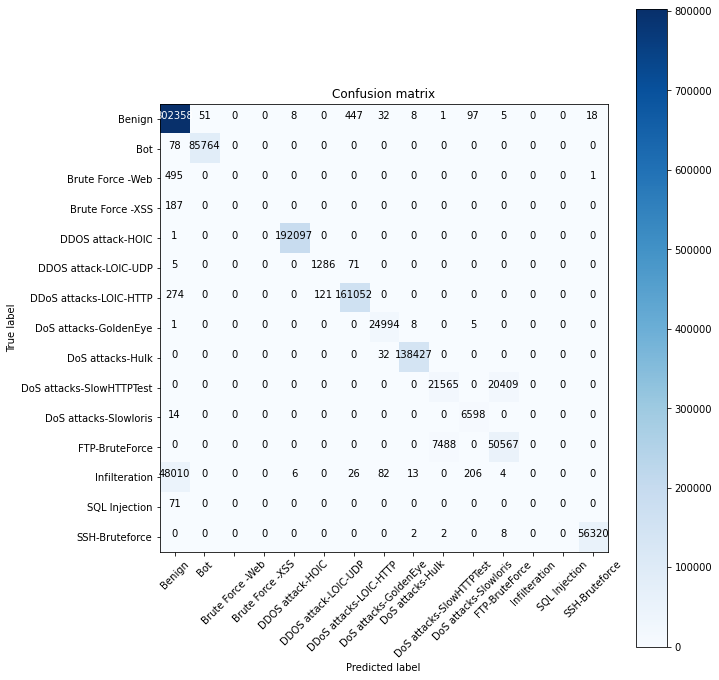

In [40]:


#outcomes = ['DoS', 'normal','Probe' ,'R2L', 'U2R']
class_names=outcomes


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))

# Data Test

In [41]:

#Data Test
result_test = dnn.evaluate(test,ylabel_test)
for name, value in zip(dnn.metrics_names, result_test):
    print(name, value)
    
print("%s: %.2f%%" % (dnn.metrics_names[1], result_test[1]*100))


404836/404836 [==============================] - 5s 14us/step
loss 0.5164569477504294
acc 0.952076890395123
acc: 95.21%


In [0]:

##prediksi data Train
#y_test=y_test.to_numpy()

preds = dnn.predict(test)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(ylabel_test, axis=1)



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

                  Benign    0.94326   0.99911   0.97038    201238
                     Bot    0.99939   0.99874   0.99907     21479
        Brute Force -Web    0.00000   0.00000   0.00000       115
        Brute Force -XSS    0.00000   0.00000   0.00000        43
        DDOS attack-HOIC    0.99996   0.99998   0.99997     48006
    DDOS attack-LOIC-UDP    0.87692   0.92935   0.90237       368
  DDoS attacks-LOIC-HTTP    0.99617   0.99682   0.99650     40219
   DoS attacks-GoldenEye    0.99254   0.99935   0.99593      6123
        DoS attacks-Hulk    0.99986   0.99965   0.99976     34758
DoS attacks-SlowHTTPTest    0.74255   0.51555   0.60857     10484
   DoS attacks-Slowloris    0.95593   0.99816   0.97659      1630
          FTP-BruteForce    0.71221   0.87040   0.78340     14452
           Infilteration    0.00000   0.00000   0.00000     11892
           SQL Injection    0.00000   0.00000   0.00000        16
         

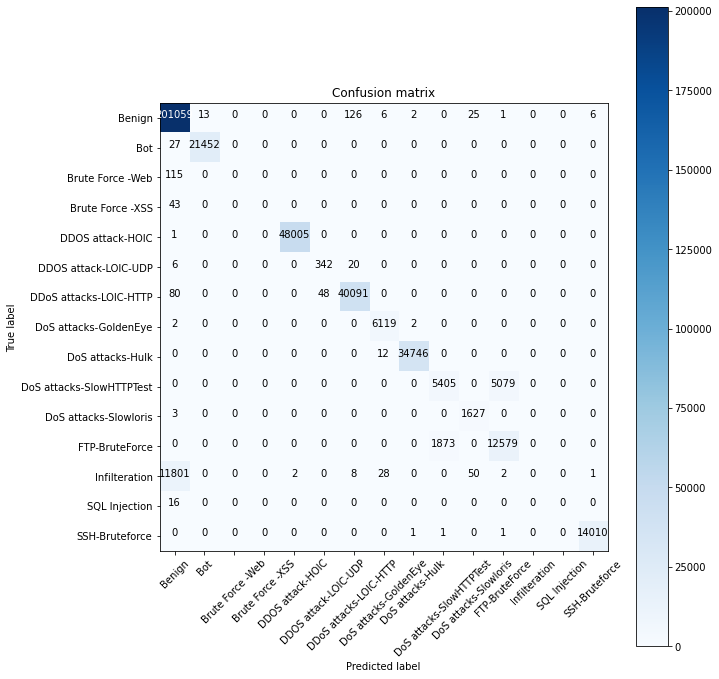

In [43]:
target_names = ["Class {}".format(i) for i in range(15)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))

In [52]:

history2a.history['acc']

[0.9546436301769575,
 0.9742483704533065,
 0.9749245823079512,
 0.9754749693543258,
 0.9758470402612192,
 0.9759188298755955,
 0.9759991107354629,
 0.9761951812961629,
 0.9763472517704066,
 0.9763310412118704,
 0.9764591818149008,
 0.9764746204413595,
 0.9765703399276855,
 0.9766760945218169,
 0.9766614278254113,
 0.9767594631063135,
 0.9767463402735107,
 0.9769308318644587,
 0.9769501301476241,
 0.9770751830243689,
 0.9771222708361905,
 0.9772156745294128,
 0.9772187622547781,
 0.9772720255169625,
 0.977341499338051,
 0.9772967273198853,
 0.9773762362484112,
 0.977348446719755,
 0.9774642364209558,
 0.9774341310990117]